# Notebook 4: Efficient Location and Time Series Access Using Polytope Feature Extraction

Notebook 4 showcases efficient geo-location and time series access using polytope feature extraction. By leveraging this feature, we significantly reduce data retrieval from storage, optimizing workflows and resource utilization.

## Installation
See instruction in [Polytope installation](https://github.com/MeteoSwiss/nwp-fdb-polytope-demo/blob/main/README.md#Installation-1)

1. **Configuring Access to Polytope**

In [ ]:
import os
import dataclasses as dc
from meteodatalab import mars

os.environ["POLYTOPE_USER_KEY"] = "xxxxxxxxxxxxx"
os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"
os.environ["POLYTOPE_LOG_LEVEL"] = "INFO"


2. **Selecting geo-location point of interest**

In [2]:
zrh = mars.Point(0, 0)

In [3]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 6
rounded_hour = (past_time.hour // 6) * 6
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time

('20250702', '0600')

3. **Querying the data** <br>
The `feature` attribute tells polytope to extract **only the relevant data at the given point**.
The amount of data that is retrieved from storage is signficantly reduced.

In [6]:
request = mars.Request(
    param="T_2M",
    date=date,
    time=time,
    model=mars.Model.ICON_CH1_EPS,
    levtype=mars.LevType.SURFACE,
    number=2,
    feature=mars.TimeseriesFeature(
        points=[zrh],
        range=mars.Range(start=0, end=120),
        time_axis="step",
    )
)

In [7]:
from meteodatalab import mch_model_data

ds = mch_model_data.get_from_polytope(request)

2025-07-02 18:40:24 - INFO - Sending request...
{'request': 'class: od\n'
            "date: '20250702'\n"
            "expver: '0001'\n"
            'feature:\n'
            '  axes:\n'
            '  - latitude\n'
            '  - longitude\n'
            '  points:\n'
            '  - - 0.0\n'
            '    - 0.0\n'
            '  range:\n'
            '    end: 120\n'
            '    start: 0\n'
            '  time_axis: step\n'
            '  type: timeseries\n'
            'levtype: sfc\n'
            'model: icon-ch1-eps\n'
            'number: 2\n'
            "param: '500011'\n"
            'stream: enfo\n'
            "time: '0600'\n"
            'type: ememb\n',
 'verb': 'retrieve'}


2025-07-02 18:40:24 - INFO - Request accepted. Please poll ./f6c4b17e-aeae-473b-9a53-c383c2a62ffe for status
2025-07-02 18:40:24 - INFO - Checking request status (f6c4b17e-aeae-473b-9a53-c383c2a62ffe)...
2025-07-02 18:40:24 - INFO - The current status of the request is 'queued'
2025-07-02 18:40:25 - INFO - The current status of the request is 'processing'


HTTPResponseError: Polytope error
Situation: trying to download data
Description: HTTP CLIENT ERROR (400)
URL: https://polytope-dev.mchml.cscs.ch:443/api/v1/requests/f6c4b17e-aeae-473b-9a53-c383c2a62ffe
HTTP method: GET
Request header/body contents:
{'headers': {'Authorization': 'Bearer **********1VCQ'}, 'json': None}
Expected responses: 200, 202
Received response: CLIENT ERROR (400)
Details:
Request failed with error:
Matched datasource gribjump-ch1

Error in function 'gribjump_new_axes': Too many retries: 5

4. **Visualizing the data**

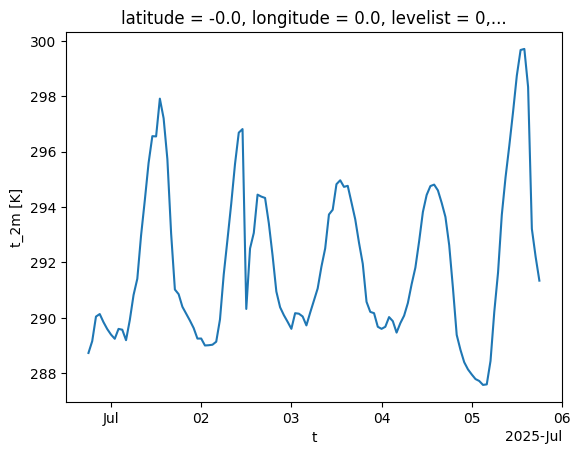

In [14]:
ds["t_2m"].plot()

5. **Plotting ensemble members of timeseries**

In [15]:
# mars.Request is a dataclass
requests = [
    dc.replace(request, number=num, ) for num in range(1, 11)
]
requests

[Request(param='T_2M', date='20250630', time='1800', expver='0001', levelist=None, number=1, step=None, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH2-EPS', stream='enfo', type='ememb', feature=TimeseriesFeature(points=[Point(lat=0, lon=0)], time_axis='step', range=Range(start=0, end=120, step=None), axes=('latitude', 'longitude'), type=<FeatureType.TIMESERIES: 'timeseries'>)),
 Request(param='T_2M', date='20250630', time='1800', expver='0001', levelist=None, number=2, step=None, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH2-EPS', stream='enfo', type='ememb', feature=TimeseriesFeature(points=[Point(lat=0, lon=0)], time_axis='step', range=Range(start=0, end=120, step=None), axes=('latitude', 'longitude'), type=<FeatureType.TIMESERIES: 'timeseries'>)),
 Request(param='T_2M', date='20250630', time='1800', expver='0001', levelist=None, number=3, step=None, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH2-EPS', stream='enfo

In [16]:
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=5) as exec:
  ememb_ds = list(exec.map(mch_model_data.get_from_polytope, requests))

DEBUG:polytope.api.Client.HVDL9K:Gathered Polytope client configuration:
{'address': 'https://polytope-dev.mchml.cscs.ch',
 'insecure': False,
 'key_path': PosixPath('/users/cosuna/.polytopeapirc'),
 'log_file': None,
 'log_level': 'INFO',
 'password': None,
 'port': None,
 'quiet': False,
 'skip_tls': False,
 'user_email': None,
 'user_key': 'eyJhbGciOiJIUzUxMiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICI5MzlkY2Q5YS0zYmViLTQyZDktOTc3Yy00ODljOTRkNWI1NmMifQ.eyJpYXQiOjE3NDcyMTYzNzAsImp0aSI6IjU1Y2Y4OTc2LTRhZTUtNGQwOS1hZDY0LWM2M2FlNDVlMmZlZiIsImlzcyI6Imh0dHBzOi8vc2VydmljZWRlcGwubWV0ZW9zd2lzcy5jaC9hdXRoL3JlYWxtcy9tZXRlb3N3aXNzLmNoIiwiYXVkIjoiaHR0cHM6Ly9zZXJ2aWNlZGVwbC5tZXRlb3N3aXNzLmNoL2F1dGgvcmVhbG1zL21ldGVvc3dpc3MuY2giLCJzdWIiOiJiNTFkZTMzNy1mYTgzLTQ3ZTgtOTc1Ni0zMjYwYTQ4MGJkOWEiLCJ0eXAiOiJPZmZsaW5lIiwiYXpwIjoiYXBpLXRva2VuIiwic2lkIjoiZTA3YWFkM2QtNDk4Yi00ZTYxLWI0YWQtYmRhZTUwMGQ1ZGUzIiwic2NvcGUiOiJvcGVuaWQgd2ViLW9yaWdpbnMgcHJvZmlsZSBvZmZsaW5lX2FjY2VzcyByb2xlcyBlbWFpbCBiYXNpYyJ9.WfOHaLG1o5qgEegUUMCw5FIV4k

RuntimeError: /scratch/mch/cosuna/nwp-fdb-polytope-demo/.venv/share/eccodes-cosmo-resources/definitions:/MEMFS/definitions does not exist

In [ ]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

labels = []

plt.figure()

data_matrix = []
for mem_ds in ememb_ds:
    ds_xr = mem_ds["t_2m"]
    label = f"Member {ds_xr['number'].values[0]}"
    data = ds_xr.values.flatten()
    data_matrix.append(data)
    time = ds_xr.t.values
    plt.plot(time, data, label=label)

mean_t = np.mean(data_matrix, axis=0)
plt.plot(time, mean_t, label="Mean", color="black")

plt.xlabel("t")
plt.ylabel("t_2m")
plt.legend()
